## Baseline model 

As a baseline model we will use ResNet 18, first with its pre-trained weights

Source: https://www.pluralsight.com/resources/blog/guides/introduction-to-resnet

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

## Data preprocessing

In [45]:
labels = pd.read_csv('selected_labels.csv')
labels = labels.drop(columns=['Ball', 'Gate', 'referee Image'])


In [46]:
LABELS = [
    'Start/Restar the game',
    'The joy of the players',
    'yellow card',
    'Red Card',
    'Stadium View',
    'Penalty Image',
    'Free Kick',
    'Generic Moment'
]

In [4]:
# visualize the mapping from label names to indices
label_to_index = {label: idx for idx, label in enumerate(LABELS)}
label_to_index

{'Start/Restar the game': 0,
 'The joy of the players': 1,
 'yellow card': 2,
 'Red Card': 3,
 'Stadium View': 4,
 'Penalty Image': 5,
 'Free Kick': 6,
 'Generic Moment': 7}

In [50]:
labels['label'] = labels[LABELS].idxmax(axis=1).map({label: idx for idx, label in enumerate(LABELS)})
labels['label'] = labels['label'].astype(int)


In [6]:
labels['label'].value_counts()

label
4    3209
6    2020
7    2009
1    1329
2     586
5     452
0     325
3      70
Name: count, dtype: int64

In [52]:
labels = labels.drop(columns=LABELS)

In [53]:
# ==== Config ====
batch_size = 32
learning_rate = 1e-3
num_epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [54]:
# ==== Custom Dataset ====
class MatchDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, str(row['Image Number']) + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = row['label']

        if self.transform:
            image = self.transform(image)
        return image, label


In [55]:
# ==== Transforms ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# ==== Load Data ====
image_path = 'data/selected_images'
dataset = MatchDataset(labels, image_path, transform)

train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [56]:
# ==== Model ====
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(LABELS))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# ==== Training Loop ====
train_acc, val_acc, train_loss, val_loss = [], [], [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total * 100
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"[{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.2f}%")

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), 'resnet18_football_best.pth')
        print("✅ Saved new best model.")

print("Training complete.")

[1/10] Train Loss: 0.7952, Acc: 72.69%, Val Loss: 0.6358, Acc: 78.57%
✅ Saved new best model.
[2/10] Train Loss: 0.5155, Acc: 82.79%, Val Loss: 0.5917, Acc: 79.37%
✅ Saved new best model.
[3/10] Train Loss: 0.4240, Acc: 86.03%, Val Loss: 0.5588, Acc: 81.98%
✅ Saved new best model.
[4/10] Train Loss: 0.3189, Acc: 89.42%, Val Loss: 0.5234, Acc: 82.78%
✅ Saved new best model.
[5/10] Train Loss: 0.2528, Acc: 91.40%, Val Loss: 0.7841, Acc: 78.46%
[6/10] Train Loss: 0.2171, Acc: 92.39%, Val Loss: 0.6429, Acc: 82.84%
[7/10] Train Loss: 0.1612, Acc: 94.43%, Val Loss: 0.5706, Acc: 85.34%
[8/10] Train Loss: 0.1376, Acc: 95.08%, Val Loss: 0.5845, Acc: 85.23%
[9/10] Train Loss: 0.1025, Acc: 96.35%, Val Loss: 0.6911, Acc: 83.21%
[10/10] Train Loss: 0.0947, Acc: 96.84%, Val Loss: 0.5839, Acc: 84.49%
Training complete.


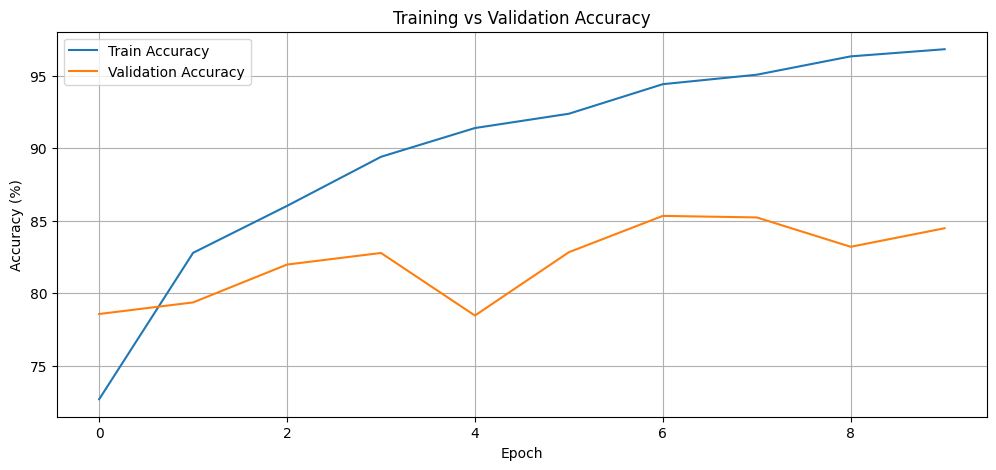

In [14]:
# ==== Accuracy Plot ====
plt.figure(figsize=(12, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.title("Training vs Validation Accuracy")
plt.show()

### Confusion matrix

In [58]:
train_val_df, test_df = train_test_split(labels, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

train_dataset = MatchDataset(train_df, image_path, transform)
val_dataset = MatchDataset(val_df, image_path, transform)
test_dataset = MatchDataset(test_df, image_path, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [59]:
# ==== Load Best Model ====
model.load_state_dict(torch.load('resnet18_football_best.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [60]:

# ==== Inference on Test Set ====
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

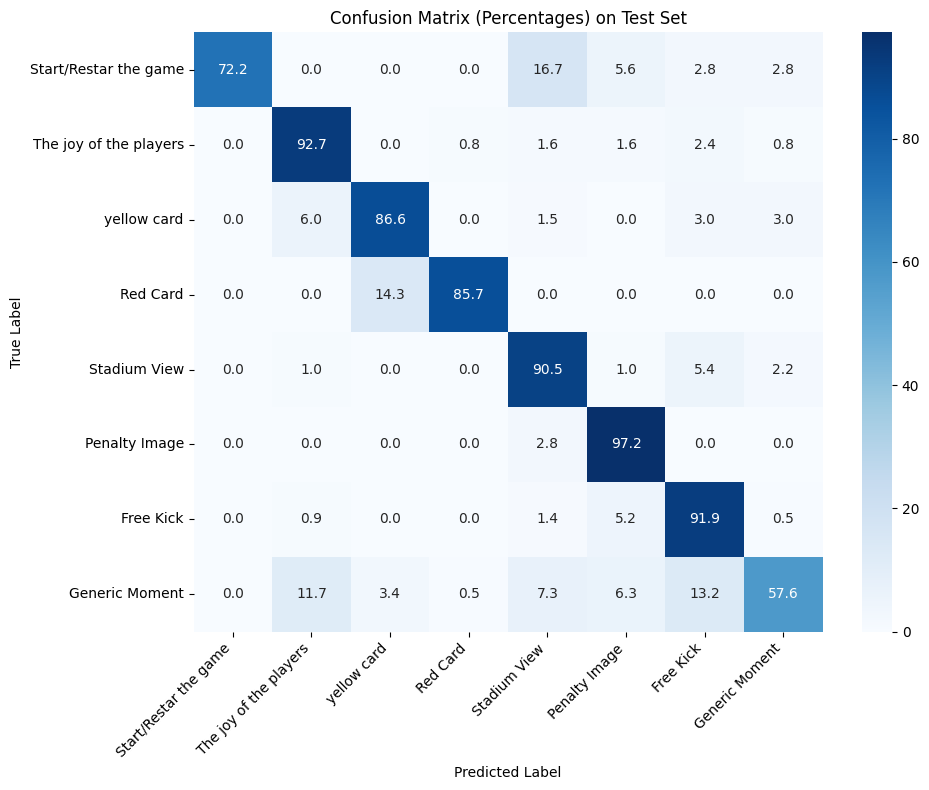

In [61]:
# ==== Compute Confusion Matrix ====
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LABELS))))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages) on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [62]:
import numpy as np

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

class_correct = [0] * len(LABELS)
class_total = [0] * len(LABELS)

for i in range(len(all_labels)):
    label = all_labels[i]
    pred = all_preds[i]
    class_total[label] += 1
    if pred == label:
        class_correct[label] += 1

class_accuracies = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

# Print per-class accuracy as table
print(f"{'Class':<25}{'Accuracy':>10}")
print("-" * 35)
for label, acc in zip(LABELS, class_accuracies):
    print(f"{label:<25}{acc:>9.2f}%")


Class                      Accuracy
-----------------------------------
Start/Restar the game        72.22%
The joy of the players       92.68%
yellow card                  86.57%
Red Card                     85.71%
Stadium View                 90.48%
Penalty Image                97.22%
Free Kick                    91.94%
Generic Moment               57.56%


---

vedere CNN su drive di lomurno e vedere aree delle immagini che si attivano quando fa inference 

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from matplotlib import gridspec
import random
from tqdm.notebook import tqdm

# Try to import captum for GradCAM - install if not available
try:
    from captum.attr import GuidedGradCam, LayerAttribution
except ImportError:
    print("Installing captum library for GradCAM...")
    !pip install captum
    from captum.attr import GuidedGradCam, LayerAttribution

# Set up device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Class names for our dataset
LABELS = [
    'Start/Restar the game',
    'The joy of the players',
    'yellow card',
    'Red Card',
    'Stadium View',
    'Penalty Image',
    'Free Kick',
    'Generic Moment'
]

In [16]:
# Dataset and DataLoader class definition
class MatchDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, str(row['Image Number']) + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = row['label']

        if self.transform:
            image = self.transform(image)
        return image, label, row['Image Number']

# Load and prepare the dataset
def load_data(data_path, image_folder):
    """
    Load and prepare the dataset
    """
    # Load labels
    labels = pd.read_csv(data_path)
    labels = labels.drop(columns=['Ball', 'Gate', 'referee Image'])
    
    # Map labels
    labels['label'] = labels[LABELS].idxmax(axis=1).map({label: idx for idx, label in enumerate(LABELS)})
    labels['label'] = labels['label'].astype(int)
    labels = labels.drop(columns=LABELS)
    
    # Prepare data transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Create dataset
    dataset = MatchDataset(labels, image_folder, transform)
    
    return dataset, labels

# Function to load a pretrained model
def load_model(model_path, num_classes=8):
    """
    Load a pretrained ResNet18 model
    """
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

In [17]:
# Functions for visualizing activations and GradCAM

def extract_activations(model, input_tensor, layer_name):
    """
    Extract activations from a specified layer
    """
    activations = {}
    
    # Hook function to record the activations
    def hook_fn(module, input, output):
        activations['activations'] = output.detach()
    
    # Register the hook
    for name, module in model.named_modules():
        if name == layer_name:
            hook = module.register_forward_hook(hook_fn)
            break
    
    # Forward pass to get activations
    _ = model(input_tensor)
    
    # Remove the hook
    hook.remove()
    
    return activations['activations']

def visualize_prediction(image_tensor, true_label, model):
    """
    Visualize the model's prediction for a given image
    """
    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor.unsqueeze(0).to(device))
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0).cpu().numpy()
        predicted_class = torch.argmax(outputs, dim=1).item()
    
    # Display image and prediction
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Display original image
    img_np = image_tensor.cpu().numpy().transpose(1, 2, 0)
    # De-normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)
    ax1.imshow(img_np)
    ax1.set_title(f'True class: {LABELS[true_label]}', fontsize=14)
    ax1.axis('off')
    
    # Display prediction bar chart
    y_pos = np.arange(len(LABELS))
    ax2.barh(y_pos, probabilities, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(LABELS)
    ax2.invert_yaxis()  # Labels read top-to-bottom
    ax2.set_xlabel('Probability')
    ax2.set_title(f'Prediction: {LABELS[predicted_class]}\nConfidence: {probabilities[predicted_class]:.3f}', fontsize=14)
    ax2.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class, probabilities

def visualize_layer_activations(model, image_tensor, layer_name, num_channels=16, figsize=(15, 10)):
    """
    Visualize activations from a specific layer
    """
    # Get the activations
    activations = extract_activations(model, image_tensor.unsqueeze(0).to(device), layer_name)
    
    # Determine grid dimensions based on number of channels to show
    channels_to_show = min(num_channels, activations.shape[1])
    rows = int(np.ceil(channels_to_show / 4))
    
    # Display activations
    fig, axes = plt.subplots(rows, 4, figsize=figsize)
    axes = axes.flatten() if rows > 1 else axes
    
    for i in range(channels_to_show):
        activation = activations[0, i].cpu().numpy()
        axes[i].imshow(activation, cmap='viridis')
        axes[i].set_title(f"Channel {i}")
        axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(channels_to_show, len(axes)):
        if rows > 1 or i < len(axes):  # Check if the index is valid
            axes[i].axis('off')
    
    plt.suptitle(f"Activations from {layer_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def visualize_gradcam(model, image_tensor, target_class, layer_name='layer4.1.conv2'):
    """
    Visualize Grad-CAM activation maps for a specific class
    """
    # Ensure the image tensor is on the correct device
    image_tensor = image_tensor.to(device)
    
    # Find the target layer
    target_layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_layer = module
            break
    
    if target_layer is None:
        print(f"Layer {layer_name} not found. Available layers:")
        for name, _ in model.named_modules():
            if isinstance(module, nn.Conv2d):
                print(f" - {name}")
        return
    
    # Create GuidedGradCam object
    guided_gc = GuidedGradCam(model, target_layer)
    
    # Get attribution
    input_tensor = image_tensor.unsqueeze(0).requires_grad_()
    attribution = guided_gc.attribute(input_tensor, target=target_class)
    
    # Resize attribution to match input dimensions
    attribution = LayerAttribution.interpolate(attribution, (224, 224))
    
    # Process attribution for visualization
    attribution_np = attribution.detach().cpu().numpy()[0].transpose(1, 2, 0)
    if attribution_np.shape[2] == 3:
        attribution_np = np.mean(attribution_np, axis=2)
    
    # Normalize for better visualization
    attribution_np = np.maximum(attribution_np, 0)
    if np.max(attribution_np) - np.min(attribution_np) > 1e-8:  # Avoid division by zero
        attribution_np = (attribution_np - np.min(attribution_np)) / (np.max(attribution_np) - np.min(attribution_np))
    
    # Prepare the original image for display
    img_np = image_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)
    
    # Create figure with 3 subplots: original image, heatmap, and overlay
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Display original image
    axes[0].imshow(img_np)
    axes[0].set_title(f'Original Image\nClass: {LABELS[target_class]}', fontsize=14)
    axes[0].axis('off')
    
    # Display attribution map
    im = axes[1].imshow(attribution_np, cmap='jet')
    axes[1].set_title('Grad-CAM Attention Map', fontsize=14)
    axes[1].axis('off')
    
    # Add a colorbar to the heatmap
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Display overlay
    axes[2].imshow(img_np)
    axes[2].imshow(attribution_np, cmap='jet', alpha=0.5)
    axes[2].set_title('Grad-CAM Overlay', fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [34]:
# check how many images are in the dataset
labels, dataset = load_data('selected_labels.csv', 'data/selected_images')
print(f"Total images in dataset: {len(dataset)}")


Total images in dataset: 10000


In [30]:
# Let's load our model and dataset

# Set paths - adjust these to match your file locations
model_path = 'resnet18_football_best.pth'  # Path to your saved model
data_path = 'selected_labels.csv'          # Path to your labels file
image_folder = 'data/selected_images'      # Path to your images folder

# Load the dataset
dataset, labels_df = load_data(data_path, image_folder)
print(f"Dataset loaded with {len(dataset)} images")

# Count the number of examples per class
class_counts = labels_df['label'].value_counts().sort_index()
for i, count in enumerate(class_counts):
    print(f"{LABELS[i]}: {count} images")

# Load the pretrained model
model = load_model(model_path, len(LABELS))
print("Model loaded successfully!")

Dataset loaded with 10000 images
Start/Restar the game: 325 images
The joy of the players: 1329 images
yellow card: 586 images
Red Card: 70 images
Stadium View: 3209 images
Penalty Image: 452 images
Free Kick: 2020 images
Generic Moment: 2009 images


/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!


In [ ]:
# Visualize a single random example

# Get a random sample from the dataset
random_idx = random.randint(0, len(dataset) - 1)
image_tensor, label, image_id = dataset[random_idx]

print(f"Selected image ID: {image_id}, true label: {LABELS[label]}")

# Visualize prediction
predicted_class, probabilities = visualize_prediction(image_tensor, label, model)

# Visualize GradCAM for the true class
print("\nGrad-CAM visualization for the true class:")
visualize_gradcam(model, image_tensor, label)

# If prediction is different from true class, also show GradCAM for predicted class
if predicted_class != label:
    print(f"\nGrad-CAM visualization for the predicted class (misclassification):")
    visualize_gradcam(model, image_tensor, predicted_class)

# Visualize activations from different layers
print("\nActivations from layer1 (first convolutional block):")
visualize_layer_activations(model, image_tensor, 'layer1', num_channels=16)

print("\nActivations from layer2 (second convolutional block):")
visualize_layer_activations(model, image_tensor, 'layer2', num_channels=16)

In [35]:
# Function to analyze multiple examples for each class

def visualize_examples_by_class(model, dataset, num_per_class=2):
    """
    Visualize examples from each class with activation maps
    """
    # Create a dictionary to store indices by class
    class_indices = {c: [] for c in range(len(LABELS))}
    
    # Collect indices for each class
    for idx in range(len(dataset)):
        _, label, _ = dataset[idx]
        class_indices[label].append(idx)
    
    # For each class, select some random examples
    for class_idx in range(len(LABELS)):
        if len(class_indices[class_idx]) == 0:
            print(f"No examples found for class: {LABELS[class_idx]}")
            continue
        
        # Sample images for this class
        sample_indices = random.sample(class_indices[class_idx], 
                                       min(num_per_class, len(class_indices[class_idx])))
        
        print(f"\n{'='*50}")
        print(f"Class: {LABELS[class_idx]} - Visualizing {len(sample_indices)} examples")
        print(f"{'='*50}")
        
        # Visualize each sampled image
        for idx in sample_indices:
            image_tensor, label, image_id = dataset[idx]
            
            print(f"\nImage ID: {image_id}")
            
            # Visualize prediction
            predicted_class, probabilities = visualize_prediction(image_tensor, label, model)
            
            # Visualize GradCAM
            visualize_gradcam(model, image_tensor, label)
            
            # Show activations from first layers
            visualize_layer_activations(model, image_tensor, 'layer1', num_channels=8)
            
            print(f"{'-'*50}")

# Run with 2 examples per class (adjust as needed)
visualize_examples_by_class(model, dataset, num_per_class=1)

KeyError: 0

In [ ]:
# Analyze model performance using GradCAM

def analyze_misclassifications(model, dataset, num_samples=30):
    """
    Analyze model misclassifications using GradCAM
    """
    # Create a dataloader for efficiently processing multiple samples
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Keep track of correct and incorrect predictions
    correct_count = 0
    incorrect_samples = []
    
    # Process samples
    for i, (image, label, image_id) in enumerate(tqdm(dataloader, desc="Evaluating model", total=num_samples)):
        if i >= num_samples:
            break
            
        image = image.to(device)
        
        # Get prediction
        model.eval()
        with torch.no_grad():
            outputs = model(image)
            predicted = torch.argmax(outputs, dim=1).item()
            
        # Record result
        if predicted == label.item():
            correct_count += 1
        else:
            incorrect_samples.append((image.squeeze(0), label.item(), predicted, image_id.item()))
    
    # Calculate accuracy on the samples
    accuracy = correct_count / num_samples
    print(f"\nAccuracy on {num_samples} samples: {accuracy:.2%}")
    print(f"Found {len(incorrect_samples)} misclassifications")
    
    # Visualize misclassifications
    if len(incorrect_samples) > 0:
        num_to_visualize = min(5, len(incorrect_samples))
        print(f"\nVisualizing {num_to_visualize} misclassifications with GradCAM:")
        
        for i in range(num_to_visualize):
            image, true_label, pred_label, image_id = incorrect_samples[i]
            
            print(f"\n{'-'*50}")
            print(f"Misclassification {i+1}/{num_to_visualize}")
            print(f"Image ID: {image_id}")
            print(f"True class: {LABELS[true_label]}")
            print(f"Predicted class: {LABELS[pred_label]}")
            
            # Visualize prediction
            visualize_prediction(image, true_label, model)
            
            # Visualize GradCAM for true class
            print("\nGrad-CAM for TRUE class (what the model should have focused on):")
            visualize_gradcam(model, image, true_label)
            
            # Visualize GradCAM for predicted class
            print("\nGrad-CAM for PREDICTED class (what the model actually focused on):")
            visualize_gradcam(model, image, pred_label)
            
            print(f"{'-'*50}")
    
    return accuracy, incorrect_samples

# Run the analysis
accuracy, misclassifications = analyze_misclassifications(model, dataset, num_samples=50)

In [ ]:
# Advanced feature visualization: Occlusion sensitivity

def occlusion_sensitivity(model, image_tensor, true_label, patch_size=8, stride=8):
    """
    Visualize model's sensitivity to image regions by occluding patches
    """
    # Create a copy of the image tensor
    image = image_tensor.clone().unsqueeze(0).to(device)
    
    # Get the original prediction and probability
    model.eval()
    with torch.no_grad():
        original_output = model(image)
        original_prob = torch.nn.functional.softmax(original_output, dim=1)[0, true_label].item()
    
    # Store sensitivity map
    width, height = image.shape[2], image.shape[3]
    sensitivity_map = torch.zeros((height, width))
    
    # Create a gray occluding patch
    occlusion_value = 0.5  # Gray value
    occluder = torch.ones(3, patch_size, patch_size) * occlusion_value
    occluder = occluder.to(device)
    
    print(f"Generating occlusion sensitivity map (this may take a while)...")
    
    # Iterate over the image with the occluding patch
    for h_pos in tqdm(range(0, height - patch_size + 1, stride), desc="Occlusion analysis"):
        for w_pos in range(0, width - patch_size + 1, stride):
            # Create an occluded version of the image
            occluded_image = image.clone()
            
            # Apply the occluder
            occluded_image[0, :, h_pos:h_pos+patch_size, w_pos:w_pos+patch_size] = occluder
            
            # Forward pass with the occluded image
            with torch.no_grad():
                output = model(occluded_image)
                prob = torch.nn.functional.softmax(output, dim=1)[0, true_label].item()
            
            # Calculate drop in probability (more drop = more important region)
            drop = original_prob - prob
            
            # Update sensitivity map
            sensitivity_map[h_pos:h_pos+patch_size, w_pos:w_pos+patch_size] += drop
    
    # Normalize the sensitivity map
    if torch.max(sensitivity_map) > 0:
        sensitivity_map = (sensitivity_map - torch.min(sensitivity_map)) / (torch.max(sensitivity_map) - torch.min(sensitivity_map))
    
    # Visualize the results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Display original image
    img_np = image_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)
    axes[0].imshow(img_np)
    axes[0].set_title(f'Original Image\nClass: {LABELS[true_label]}', fontsize=14)
    axes[0].axis('off')
    
    # Display sensitivity map
    sens_np = sensitivity_map.cpu().numpy()
    im = axes[1].imshow(sens_np, cmap='hot')
    axes[1].set_title('Occlusion Sensitivity Map', fontsize=14)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Display overlay
    axes[2].imshow(img_np)
    axes[2].imshow(sens_np, cmap='hot', alpha=0.5)
    axes[2].set_title('Sensitivity Overlay', fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return sensitivity_map

# Let's analyze a sample image with occlusion sensitivity
random_idx = random.randint(0, len(dataset) - 1)
image_tensor, label, image_id = dataset[random_idx]

print(f"Selected image ID: {image_id}, label: {LABELS[label]}")
visualize_prediction(image_tensor, label, model)

# Generate occlusion sensitivity map
sensitivity_map = occlusion_sensitivity(model, image_tensor, label, patch_size=24, stride=12)

# Compare with GradCAM for the same image
print("\nComparing with GradCAM:")
visualize_gradcam(model, image_tensor, label)

In [ ]:
# Function to summarize and compare different visualization techniques

def summarize_visualizations(model, dataset, num_samples=3):
    """
    Compare different visualization techniques on selected samples
    """
    # Randomly select samples
    indices = random.sample(range(len(dataset)), num_samples)
    
    for i, idx in enumerate(indices):
        image_tensor, label, image_id = dataset[idx]
        
        print(f"\n{'='*80}")
        print(f"Sample {i+1}/{num_samples} - Image ID: {image_id}, Class: {LABELS[label]}")
        print(f"{'='*80}")
        
        # Show prediction
        predicted_class, _ = visualize_prediction(image_tensor, label, model)
        
        # Show GradCAM for the true class
        print("\nGrad-CAM visualization:")
        visualize_gradcam(model, image_tensor, label)
        
        # Show occlusion sensitivity
        print("\nOcclusion sensitivity analysis:")
        occlusion_sensitivity(model, image_tensor, label, patch_size=24, stride=16)
        
        # Show activations from key layers
        print("\nActivations from layer1:")
        visualize_layer_activations(model, image_tensor, 'layer1', num_channels=8)
        
        print("\nActivations from layer4:")
        visualize_layer_activations(model, image_tensor, 'layer4', num_channels=8)
        
        print(f"\n{'-'*80}")

# Run the comparison
summarize_visualizations(model, dataset, num_samples=2)